In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

In [2]:
def consumption(c, we, rest, gamma, nu, phi, tauc, taun):
    return (1 + tauc) * c - (1 - taun) * we * ((1 - taun) * we / ((1 + tauc) * phi * c ** gamma)) ** (1/nu) - rest

def household_guess(a_grid, e_grid, i, w, gamma, T, taun):
    wel = (1 + i) * a_grid[np.newaxis,:] + (1 - taun) * w * e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1 + i) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p, a_grid, e_grid, i, w, T, beta, gamma, nu, phi, tauc, taun):

    we = w * e_grid

    c_prime = (beta * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t
    n_prime = ((1 - taun) * we[:,np.newaxis] / ((1 + tauc) * phi * c_prime ** gamma)) ** (1/nu)

    new_grid = ((1 + tauc) * c_prime + a_grid[np.newaxis,:] - (1 - taun) * we[:,np.newaxis] * n_prime 
                - T[:,np.newaxis])
    wel = (1 + i) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + (1 - taun) * we[:,np.newaxis] * n + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + i) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = wel[indexes_asset[1]] - a_grid[0] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],
                                                                 rest,gamma,nu,phi,tauc,taun),aa,bb)
        n[indexes_asset] = ((1 - taun) * we[indexes_asset[0]] 
                            / ((1 + tauc) * phi * c[indexes_asset] ** gamma)) ** (1/nu)
        V_prime[indexes_asset] = (1 + i) * (c[indexes_asset]) ** (-gamma)

    return V_prime, a, c, n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho = rho_e, sigma = sd_e, N = nE)
    a_grid = grids.agrid(amin = amin, amax = amax, n = nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  Transfer / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

household_inp = household.add_hetinputs([make_grid,transfers])

print(household_inp)
print(f'Inputs: {household_inp.inputs}')

def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'i', 'w', 'T', 'beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'n']
<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['i', 'w', 'beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']
Inputs: ['i', 'w', 'beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [3]:
# The rest of the code is identical to the one-asset HANK example in their notebook
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    i = rstar
    return r, i

@simple
def fiscal(i, Transfer, B, C, L, tauc, taun, w):
    govt_res = Transfer + (1 + i) * B(-1) - tauc * C - taun * w * L - B
    Deficit = tauc * C + taun * w * L - Transfer # primary surplus
    Trans = Transfer
    return govt_res, Deficit, Trans

@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

blocks_ss = [hh_ext, firm, monetary,fiscal, nkpc_ss, mkt_clearing]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'nu', 'phi', 'tauc', 'taun', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B']
Outputs: ['A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'govt_res', 'Deficit', 'Trans', 'w', 'asset_mkt', 'labor_mkt', 'goods_mkt']


In [4]:
calibration = {'gamma': 1.0, 'nu': 1, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0, 
               'tauc': 0.1, 'taun': 0.036}

unknowns_ss = {'beta': 0.986, 'phi': 0.8, 'Transfer': 0.05}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

#plt.plot(ss0.internals['household']['a_grid'], ss0.internals['household']['n'].T)
#plt.xlabel('Assets'), plt.ylabel('Labor supply')
#plt.show()

In [5]:
# Show steady state
ss_param = [['Discount factor', ss0['beta'], 'Intertemporal elasticity', ss0['gamma']],
        ['Labor supply elasticity', 1 / ss0['nu'], 'Labor supply disutility', ss0['phi']],  
        ['Goods substitutability', ss0['mu'] / (ss0['mu'] - 1) , 'Price markup', ss0['mu']],
        ['Phillips curve slope', ss0['kappa'], 'Taylor rule inflation ', ss0['phi_pi']],
        ['Consumption tax rate', ss0['tauc'], 'Labor tax rate', ss0['taun']]]

ss_var = [['Output', ss0['N'] * ss0['Z'], 'Government debt', ss0['A']],
        ['Hours', ss0['N'], 'Transfers', ss0['Transfer']],
        ['Consumption', ss0['C'], 'Dividends', ss0['Div']], 
        ['Wage', ss0['w'], 'Marginal cost', ss0['w'] / ss0['Z']],
        ['Inflation', ss0['pi'], 'Consumption tax revenue', ss0['tauc'] * ss0['C']],
        ['Nominal interest rate', ss0['r']*(1+ss0['pi']), 'Labor tax revenue', ss0['taun']*ss0['N']*ss0['w']],
        ['Real interest rate', ss0['r'], 'Debt servicing  cost', ss0['r'] * ss0['A']]]
ss_mkt = [['Bond market', ss0['asset_mkt'], 'Labor market', ss0['labor_mkt']],
          ['Goods market (resid)', ss0['goods_mkt'], 'Government budget', ss0['govt_res']]]

dash = '-' * 73
print(dash)
print('PARAMETERS')
for i in range(len(ss_param)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_param[i][0],ss_param[i][1],ss_param[i][2],ss_param[i][3]))
print('\nVARIABLES')
for i in range(len(ss_var)):
      print('{:<24s}{:>12.3f}   {:24s}{:>10.3f}'.format(ss_var[i][0],ss_var[i][1],ss_var[i][2],ss_var[i][3]))
print('\nMARKET CLEARING')
for i in range(len(ss_mkt)):
      print('{:<24s}{:>12.0e}   {:24s}{:>10.0e}'.format(ss_mkt[i][0],ss_mkt[i][1],ss_mkt[i][2],ss_mkt[i][3]))
print(dash)


-------------------------------------------------------------------------
PARAMETERS
Discount factor                0.988   Intertemporal elasticity     1.000
Labor supply elasticity        1.000   Labor supply disutility      0.754
Goods substitutability         6.000   Price markup                 1.200
Phillips curve slope           0.100   Taylor rule inflation        0.000
Consumption tax rate           0.100   Labor tax rate               0.036

VARIABLES
Output                         0.948   Government debt              6.000
Hours                          0.948   Transfers                    0.100
Consumption                    1.000   Dividends                    0.167
Wage                           0.833   Marginal cost                0.833
Inflation                      0.000   Consumption tax revenue      0.100
Nominal interest rate          0.005   Labor tax revenue            0.028
Real interest rate             0.005   Debt servicing  cost         0.030

MARKET CLEARING

In [6]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

#print(*hank.blocks, sep='\n')

ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))
    
T = 300
exogenous = ['rstar', 'Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
#print(G)

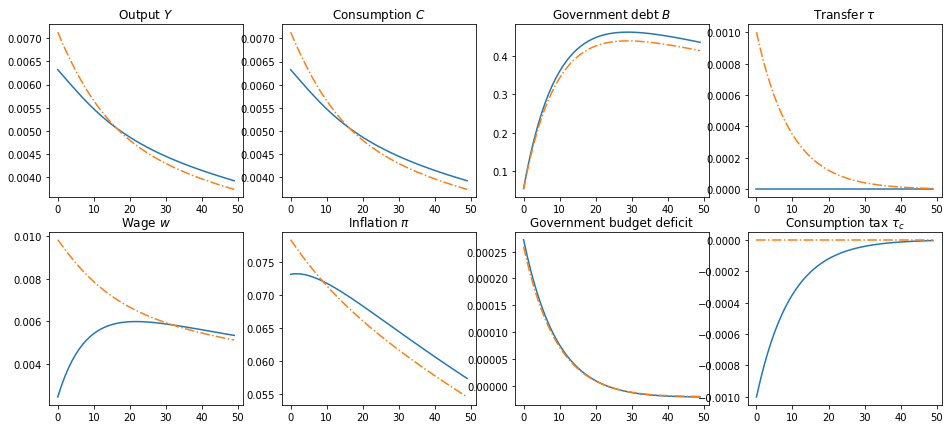

--------------------------------------------------
DIFFERENCE τc TO τ   IMPACT RATIO   CUMULATIVE SUM
--------------------------------------------------
Shocks                  1.000                0.000
Output                  0.886                0.026
Consumption             0.886                0.026
Inflation               0.933                0.371
Wage                    0.250               -0.034
Deficit                 1.049                0.002


In [10]:
# Impulse response functions
rhos = 0.9
drstar = -0.02 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.01 * rhos ** (np.arange(T)[:, np.newaxis])
dtauc = - 0.01 * rhos ** (np.arange(T)[:, np.newaxis])

dY = [G['Y']['rstar'] @ drstar, G['Y']['tauc'] @ dtauc, G['Y']['Transfer'] @ dtstar]
dC = [G['C']['rstar'] @ drstar, G['C']['tauc'] @ dtauc, G['C']['Transfer'] @ dtstar]
dN = [G['N']['rstar'] @ drstar, G['N']['tauc'] @ dtauc, G['N']['Transfer'] @ dtstar]
dB = [G['A']['rstar'] @ drstar, G['A']['tauc'] @ dtauc, G['A']['Transfer'] @ dtstar]
dw = [G['w']['rstar'] @ drstar, G['w']['tauc'] @ dtauc, G['w']['Transfer'] @ dtstar]
dp = [G['pi']['rstar'] @ drstar, G['pi']['tauc'] @ dtauc, G['pi']['Transfer'] @ dtstar]
dr = [G['r']['rstar'] @ drstar, G['r']['tauc'] @ dtauc, G['r']['Transfer'] @ dtstar]
dD = [G['Deficit']['rstar'] @ drstar, G['Deficit']['tauc'] @ dtauc, G['Deficit']['Transfer'] @ dtstar]
dd = [G['Div']['rstar'] @ drstar, G['Div']['tauc'] @ dtauc, G['Div']['Transfer'] @ dtstar]
dT = [np.zeros(T), np.zeros(T), G['Trans']['Transfer'] @ dtstar]
di = [G['i']['rstar'] @ drstar, np.zeros(T), np.zeros(T)]

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)

ax[0, 0].set_title(r'Output $Y$')
#l1, = ax[0, 0].plot(dY[0][:50, :])
l1, = ax[0, 0].plot(dY[1][:50, :] * ss0['Y'])
l2, = ax[0, 0].plot(dY[2][:50, :] * ss0['Y'],'-.')

ax[0, 1].set_title(r'Consumption $C$')
#ax[0, 1].plot(dC[0][:50, :])
ax[0, 1].plot(dC[1][:50, :] * ss0['C'])
ax[0, 1].plot(dC[2][:50, :] * ss0['C'],'-.')

ax[0, 2].set_title(r'Government debt $B$')
#ax[0, 2].plot(dB[0][:50, :])
ax[0, 2].plot(dB[1][:50, :] * ss0['A'])
ax[0, 2].plot(dB[2][:50, :] * ss0['A'],'-.')

ax[0, 3].set_title(r'Transfer $\tau$')
ax[0, 3].plot(np.zeros(50))
ax[0, 3].plot(dT[2][:50, :] * ss0['Trans'],'-.')

ax[1, 0].set_title(r'Wage $w$')
#ax[1, 0].plot(dw[0][:50, :])
ax[1, 0].plot(dw[1][:50, :] * ss0['w'])
ax[1, 0].plot(dw[2][:50, :] * ss0['w'],'-.')

ax[1, 1].set_title(r'Inflation $\pi$')
#ax[1, 1].plot(dp[0][:50, :])
ax[1, 1].plot(dp[1][:50, :])
ax[1, 1].plot(dp[2][:50, :],'-.')

#ax[1, 2].set_title(r'Real interest rate $r$')
#ax[1, 2].plot(dr[0][:50, :])
#ax[1, 2].plot(dr[1][:50, :])
#ax[1, 2].plot(dr[2][:50, :],'-.')

ax[1, 2].set_title(r'Government budget deficit')
#ax[1, 2].plot(dD[0][:50, :])
ax[1, 2].plot(-dD[1][:50, :] * ss0['Deficit'])
ax[1, 2].plot(-dD[2][:50, :] * ss0['Deficit'],'-.')

ax[1, 3].set_title(r'Consumption tax $\tau_c$')
ax[1, 3].plot(dtauc[:50] * ss0['tauc'])
ax[1, 3].plot(np.zeros(50),'-.')
plt.show()

# Difference consumption tax vs transfers
dif = [['DIFFERENCE \u03C4c vs \u03C4','IMPACT RATIO','CUMULATIVE SUM'],
      ['Shocks',np.ndarray.item(- (dtauc[:1] * ss0['tauc']) / (dT[2][:1, :] * ss0['Trans'])), - np.sum(dtauc) - np.sum(dT[2][:300])],
      ['Output',np.ndarray.item(dY[1][:1, :] / dY[2][:1, :]), np.sum(dY[1][:300, :]) - np.sum(dY[2][:300, :])],
      ['Consumption',np.ndarray.item(dC[1][:1, :] / dC[2][:1, :]), np.sum(dC[1][:300, :]) - np.sum(dC[2][:300, :])],
      ['Inflation',np.ndarray.item(dp[1][:1, :] / dp[2][:1, :]), np.sum(dp[1][:300, :]) - np.sum(dp[2][:300, :])],
      ['Wage',np.ndarray.item(dw[1][:1, :] / dw[2][:1, :]), np.sum(dw[1][:300, :]) - np.sum(dw[2][:300, :])],
      ['Deficit',np.ndarray.item(dD[1][:1, :] / dD[2][:1, :]), np.sum(dD[1][:300, :]) - np.sum(dD[2][:300, :])]]
dash = '-' * 50
for i in range(len(dif)):
    if i == 0:
        print(dash)
        print('{:<20s} {:^12s}  {:>15s}'.format(dif[i][0],dif[i][1],dif[i][2]))
        print(dash)
    else:
        print('{:<20s} {:^12.3f}  {:>15.3f}'.format(dif[i][0],dif[i][1],dif[i][2]))